In [1]:
import matplotlib.pyplot as plt
from functools import reduce
import pandas as pd
from system import FLSInventoryManagement as flsystem

In [3]:
def plotting_subplot(axes, x, functionList, clr, labels, title, kind, symbol, index, fuzzfied_vals = None, aggregated=None, specific_x_val=None):
    # Determine if `axes` is 1D or 2D
    if axes.ndim == 1:  # 1D array of subplots
        ax = axes[index]
    else:  # 2D array of subplots
        rows, cols = axes.shape
        row = index // cols
        col = index % cols
        ax = axes[row, col]

    # Plot the membership functions
    for ind in range(len(functionList)):
        ax.plot(x, functionList[ind], color=clr[ind], label=labels[ind])
    
    # Plot and shade the aggregated curve
    if aggregated is not None:
        ax.plot(x, aggregated, color='purple', label="Aggregated")
        ax.fill_between(x, aggregated, color='purple', alpha=0.3)
    
    # Add a vertical line for specific x-value
    if specific_x_val is not None:
        ax.plot([specific_x_val, specific_x_val], [0, 1], color='brown', label="Value")

    # Set subplot title, labels, and grid
    ax.set_title(f"{title} ({kind + ' ' + symbol})", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("Membership Degree")

system = flsystem()

In [ ]:
week = [i+1 for i in range(15)]
days = [55,48,41,35,25,15,8,1,-5]
inv = [4,10,17,25,32,41,49,55]
dem = [0,0.532,1.231,1.623,3,3.31,3.545,4.53]


In [26]:
dataset = pd.read_csv("inventory.csv")

# Create a list of DataFrames for each scenario
res_dataset = []
for ind in range(len(days)):
    dataset['days_bf_exp'] = days[ind]
    res = dataset.copy()
    res_dataset.append(res)

col = list(dataset.columns)

# Merge all DataFrames in the list
df = res_dataset[0]
for ind in range(1, len(res_dataset)):
    df = df.merge(res_dataset[ind], on=col, how='outer') 

df = df[['item_id','days_bf_exp','quantity']]
df = df.sort_values(['days_bf_exp','item_id'])
df.reset_index(inplace = True)
df = df[df.columns.drop(['index'])]

In [32]:
df['reorder_Quantity (Units)'] = 0.0
df['reorder_Urgency (%)'] = 0.0
selected_inputs = [
        # (-5, 4),
        # ()
]
method_quantity = 'som'
method_urgency = 'som'
for i in range(len(df)):
        quantity = df.iloc[i]['quantity']
        days_to_expiry = df.iloc[i]['days_bf_exp']
        inputs = (quantity, days_to_expiry)
        reorder_quantity, reorder_urgency = system.get_result(
            quantity, days_to_expiry, method_quantity, method_urgency
        )
        aggregated_quantity,aggregated_urgency = system.get_aggregated(
            quantity, days_to_expiry
        )
        df.at[i, 'reorder_Quantity (Units)'] = reorder_quantity
        df.at[i, 'reorder_Urgency (%)'] = reorder_urgency
        if inputs in selected_inputs:
            # Example inputs
            x = [system.get_variables("Inventory")[0], system.get_variables("Days")[0],
                system.get_variables("Quantity")[0], system.get_variables("Urgency")[0]]
            func = [system.get_variables("Inventory")[1], system.get_variables("Days")[1],
                    system.get_variables("Quantity")[1], system.get_variables("Urgency")[1]]
            clrs = [['r','g','b'],['r','g','b'],['k','r','g','b'], ['k','r','g','b']]
            labels = [['Low','Medium','High'],['Low','Medium','High'],['Zero','Low','Medium','High'],['Zero','Low','Medium','High']]
            title = ["Inventory","Days Before Expired","Reorder Quantity", "Reorder Urgency"]
            kind = ['Input','Input','Output','Output']
            symbol = [' Units', ' Days', ' Units', ' %']
            aggregated = [None,None,aggregated_quantity,aggregated_urgency]
            specific_x_val = [quantity, days_to_expiry, reorder_quantity, reorder_urgency]

            # Create subplots
            rows = 2  # Number of rows in the grid
            cols = 2  # Number of columns in the grid
            fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
            axes = axes.flatten()  # Flatten axes for easier access

            # Loop through and plot on subplots
            for i in range(len(x)):
                plotting_subplot(axes, x[i], func[i], clrs[i], labels[i], title[i], kind[i], symbol[i], i, aggregated[i], specific_x_val[i])

            # Remove any extra subplots (if len(x) < rows * cols)
            for j in range(len(x), rows * cols):
                fig.delaxes(axes[j])

            # Adjust layout
            plt.tight_layout()
            plt.show()
new_df = df.copy()
# new_df['difference'] = new_df['reorder_quantity'] - new_df['quantity']
new_df

,item_id,days_bf_exp,quantity,reorder_Quantity (Units),reorder_Urgency (%)
0,1,-5,4,45.0,95.0
1,2,-5,10,45.0,95.0
2,3,-5,17,45.0,95.0
3,4,-5,25,45.0,95.0
4,5,-5,32,45.0,95.0
...,...,...,...,...,...
58,3,55,17,0.0,0.0
59,4,55,25,0.0,0.0
60,5,55,32,0.0,0.0
61,6,55,41,0.0,0.0


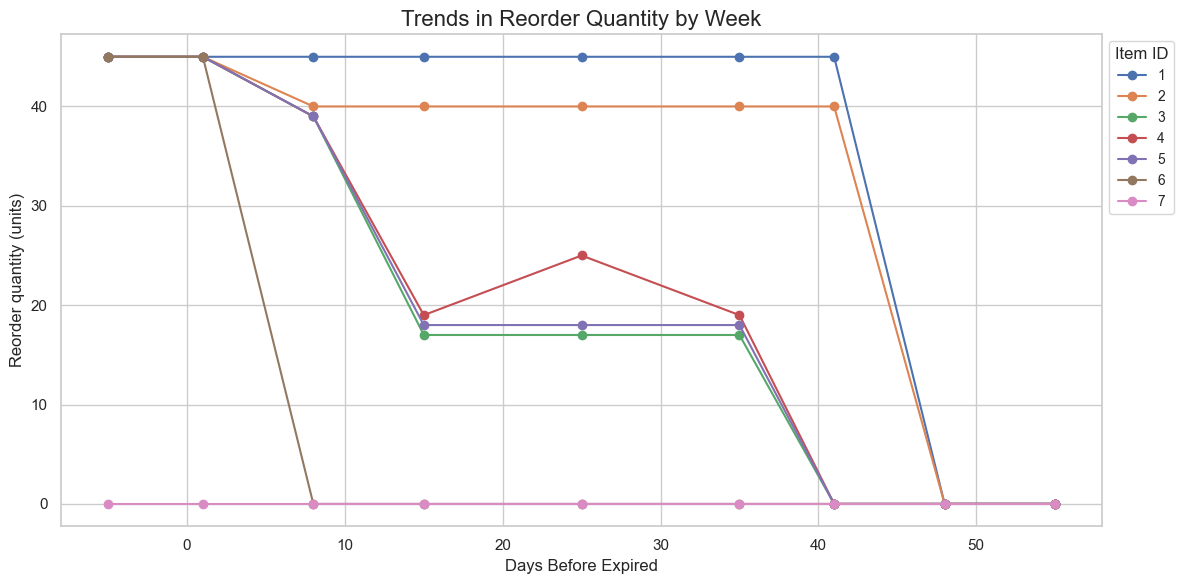

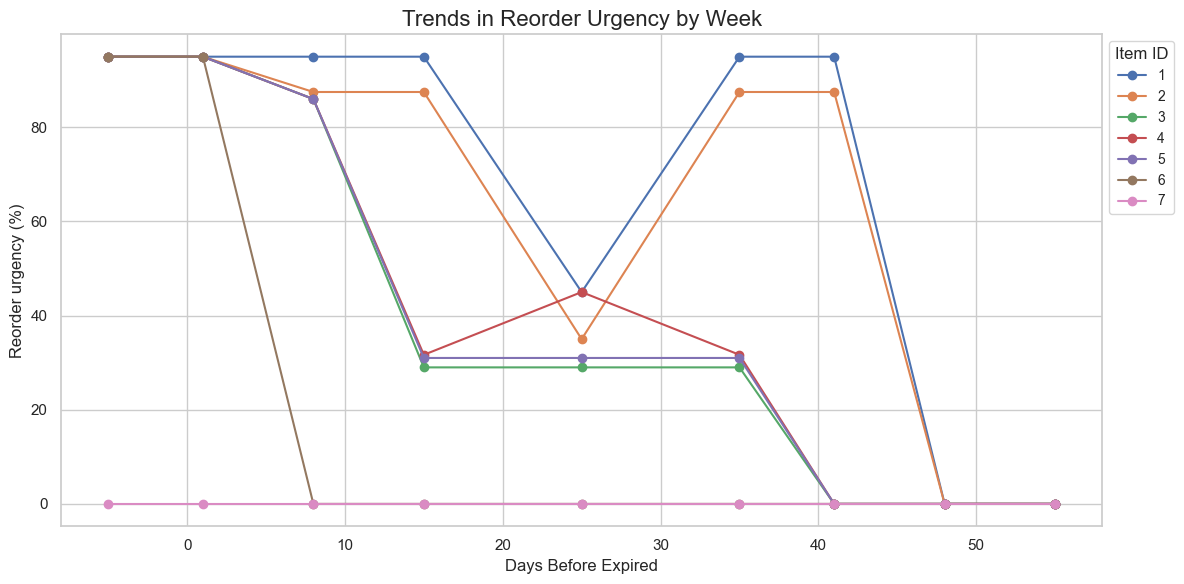

: 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
result = new_df
# Sample DataFrame (replace this with your actual data)
# result = pd.read_csv("your_result.csv")

# Function to plot trends
def plot_trends(data, y_col, title):
    plt.figure(figsize=(12, 6))
    for item_id in data['item_id'].unique():
        item_data = data[data['item_id'] == item_id]
        plt.plot(item_data['days_bf_exp'], item_data[y_col], label=item_id, marker='o')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Days Before Expired', fontsize=12)
    plt.ylabel(y_col.replace('_', ' ').capitalize(), fontsize=12)
    plt.legend(title='Item ID', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

# Plot reorder_quantity trends
plot_trends(result, y_col='reorder_Quantity (Units)', title='Trends in Reorder Quantity by Week')

# Plot reorder_urgency trends
plot_trends(result, y_col='reorder_Urgency (%)', title='Trends in Reorder Urgency by Week')
